<a href="https://colab.research.google.com/github/AkiraNom/data-analysis-notebook/blob/main/Bayesian_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import warnings
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
warnings.filterwarnings("ignore", category=FutureWarning)

Running on PyMC v5.7.2


# Happiness

The [World Happiness Report](https://worldhappiness.report/) annually publish national happiness data.

This notebook analyzes the relationship between happiness and 6 indedependent variables using Bayesian regression.

Six independent variables are:
* Income as represented by per capita GDP
* Social support
* Healthy life expectancy at birth
* Freedom to make life choices
* Generosity
* Perceptions of corruption

In [33]:
filename = 'DataForFigure2.1WHR2021C2.xls'
df = pd.read_excel(filename)

In [34]:
df.head()

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.8421,0.031646,7.904126,7.780075,10.775202,0.953603,72.000000,0.949268,-0.097760,0.185846,2.430343,1.446356,1.106192,0.740824,0.690577,0.124200,0.480524,3.253415
1,Denmark,Western Europe,7.6195,0.034657,7.687428,7.551572,10.933176,0.954410,72.699753,0.945639,0.030109,0.178838,2.430343,1.501548,1.108008,0.762862,0.686160,0.207615,0.484993,2.868296
2,Switzerland,Western Europe,7.5715,0.036243,7.642536,7.500463,11.117368,0.941742,74.400101,0.918788,0.024629,0.291698,2.430343,1.565899,1.079469,0.816415,0.653488,0.204040,0.413019,2.839148
3,Iceland,Western Europe,7.5539,0.059373,7.670271,7.437528,10.877768,0.982938,73.000000,0.955123,0.160274,0.672865,2.430343,1.482190,1.172279,0.772319,0.697701,0.292526,0.169940,2.966945
4,Netherlands,Western Europe,7.4640,0.027326,7.517559,7.410441,10.931812,0.941601,72.400116,0.913116,0.175404,0.337938,2.430343,1.501072,1.079151,0.753425,0.646585,0.302397,0.383531,2.797818


The datasheet contains 149 countries and 20 variables.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 20 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Country name                                149 non-null    object 
 1   Regional indicator                          149 non-null    object 
 2   Ladder score                                149 non-null    float64
 3   Standard error of ladder score              149 non-null    float64
 4   upperwhisker                                149 non-null    float64
 5   lowerwhisker                                149 non-null    float64
 6   Logged GDP per capita                       149 non-null    float64
 7   Social support                              149 non-null    float64
 8   Healthy life expectancy                     149 non-null    float64
 9   Freedom to make life choices                149 non-null    float64
 10  Generosity    

In [36]:
df.shape

(149, 20)

Select variables to implement in the multiple regression model

In [37]:
columns = ['Ladder score',
           'Logged GDP per capita',
           'Social support',
           'Healthy life expectancy',
           'Freedom to make life choices',
           'Generosity',
           'Perceptions of corruption']

subset = df[columns]

In [38]:
subset.describe()

,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,5.532832,9.432209,0.814726,64.992784,0.791572,-0.015149,0.727477
std,1.073923,1.158585,0.114892,6.762071,0.113315,0.150653,0.179266
min,2.522900,6.635322,0.462596,48.478001,0.381749,-0.288153,0.081959
25%,4.851800,8.540956,0.749777,59.801552,0.718051,-0.126469,0.666607
50%,5.533500,9.568728,0.831914,66.603096,0.804414,-0.036025,0.780623
75%,6.255400,10.421198,0.904702,69.599998,0.877263,0.078830,0.844619
max,7.842100,11.646564,0.982938,76.952858,0.970131,0.541553,0.939343


Since the variables have different units, the variables may not be comparable. To make the factor comparable, it is important to standardize the data before modeling. <br>

In [39]:
standardized = (subset - subset.mean()) / subset.std()
standardized

,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,2.150312,1.159166,1.208762,1.036253,1.391667,-0.548354,-3.021385
1,1.943035,1.295517,1.215779,1.139735,1.359638,0.300412,-3.060474
2,1.898338,1.454497,1.105521,1.391189,1.122684,0.264039,-2.430906
3,1.881950,1.247693,1.464085,1.184137,1.443336,1.164418,-0.304645
4,1.798238,1.294340,1.104294,1.095423,1.072623,1.264850,-2.172969
...,...,...,...,...,...,...,...
144,-1.881915,-1.300234,-0.242445,-2.409437,-0.676154,-0.765913,1.048161
145,-1.924097,0.301512,-0.265945,-0.846426,0.289658,-1.533392,0.408007
146,-1.972332,-1.515720,-2.283774,-0.531355,0.928271,0.502312,-3.127622
147,-2.223653,-1.285718,-0.559276,-1.300185,-1.013742,-0.213714,0.521691


In this exercise, I will perform a regression to predict the `ladder score` using the variables.

In [40]:
y_data = standardized['Ladder score']

These are independent variables

In [41]:
x1 = standardized[columns[1]]
x2 = standardized[columns[2]]
x3 = standardized[columns[3]]
x4 = standardized[columns[4]]
x5 = standardized[columns[5]]
x6 = standardized[columns[6]]

`b0` is the intercept and `b1` through `b6` are coefficient associated with independent variables

$y_{pred} = \beta_0 + \beta_1*x_1 + \beta_2*x_2 + \beta_3*x_3 + \beta_4*x_4 + \beta_4*x_4 + \beta_5*x_5 + \beta_6*x_6$

In [53]:
with pm.Model() as model:
    b0 = pm.Uniform('b0', -4, 4)
    b1 = pm.Uniform('b1', -4, 4)
    b2 = pm.Uniform('b2', -4, 4)
    b3 = pm.Uniform('b3', -4, 4)
    b4 = pm.Uniform('b4', -4, 4)
    b5 = pm.Uniform('b5', -4, 4)
    b6 = pm.Uniform('b6', -4, 4)
    sigma = pm.HalfNormal('sigma', 1)

    y_pred = b0 + b1*x1 + b2*x2 + b3*x3 + b4*x4 + b5*x5 + b6*x6
    y = pm.Normal('y',
                  mu=y_pred, sigma=sigma,
                  observed=y_data)

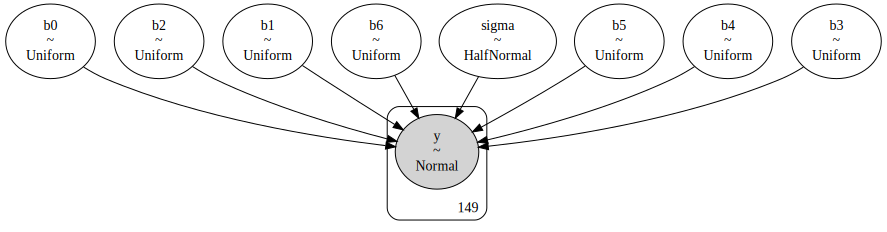

In [54]:
pm.model_to_graphviz(model)

Sampling from the joint posterior distribution

In [55]:
with model:
    trace = pm.sample(500)

In [56]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [57]:
# check the mean of the intercept
trace.posterior['b0'].values[0].mean()

0.0026120266235354675

In [58]:
# check the mean of the sigma
trace.posterior['sigma'].values[0].mean()

0.5089133993451558

In [59]:
# compute the mean for the posterior distribution of the parameters
param_names = ['b1', 'b3', 'b3', 'b4', 'b5', 'b6']

means = [trace.posterior[name].values[0].mean()
         for name in param_names]

In [60]:
def confidence_interval(sample):
  """compute the 95% confidence interval"""
  ci = np.percentile(sample, [2.5, 97.5])
  return np.round(ci, 3)

In [61]:
# compute the 95% confidence interval
cis = [confidence_interval(trace.posterior[name].values[0])
       for name in param_names]

In [62]:
index = columns[1:]
result = pd.DataFrame(index=index)
result['Posterior mean'] = np.round(means, 3)
result['95% CI'] = cis
result

,Posterior mean,95% CI
Logged GDP per capita,0.298,"[0.092, 0.477]"
Social support,0.192,"[0.039, 0.355]"
Healthy life expectancy,0.192,"[0.039, 0.355]"
Freedom to make life choices,0.210,"[0.1, 0.319]"
Generosity,0.053,"[-0.031, 0.14]"
Perceptions of corruption,-0.102,"[-0.195, -0.014]"


Based on this model, the GDP has the strongest association with the happiness. Social support, life expectancy, and freedom to make life choicese are eqully important.

Generosity and perceptions of corruption are less important contributors to happiness

In [64]:
# pm.plot_trace(trace)
# plt.tight_layout()
# plt.show()